The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [8]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Then we import the covid19_inference module.

In [9]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for Austria

In [10]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()

# extract confirmed
bd = datetime.datetime(2020,3,3) # cases began to increase heavily
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
total_cases = jhu.get_confirmed(country = "Austria", begin_date= bd, end_date = ed )

In [11]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[   8   12   14   24   25   27   51   64   56  202  151  205  158  314
  314  367  375  426  768  892  809  305 1321  748  614  517  830  562
  531  418  395  257  270  246  342  303  302  311  251  139   96  185
  110  140  119   76   78   46   78   52   77   69   77   77   49   83
   45   50   79   27]


For the choice of changing points, see https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf, https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Austria
- We assume school closures to take effect on Monday 16/03 together with the strong social distancing, https://www.reuters.com/article/us-health-coronavirus-austria/austria-closing-schools-over-coronavirus-as-border-checks-take-effect-idUSKBN20Y2YC, this is our second change point
- We take the ban on public events the 10/03 as first changepoint
- We take the 30/03 as a change point because a mask obligation in stores came into effect
- We take 11/03 and 14/03 as before and after easter as change points, because people might  have increasedly violated social distancing rules, 14/03 is also the date where it became obligatory to wear face masks on public transport



In [12]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_public_events_banned =  datetime.datetime(2020,3,10)
prior_date_confinement_begin =  datetime.datetime(2020,3,16)
# prior_date_easter_begin =  datetime.datetime(2020,4,11)

change_points = [dict(pr_mean_date_transient = prior_date_public_events_banned,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_confinement_begin,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1)]

In [13]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 8.86e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.4)
    # delay as for Germany
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [14]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 428.54:   8%|▊         | 16399/200000 [00:58<10:53, 280.88it/s]
Convergence achieved at 16400
INFO     [pymc3.variational.inference] Convergence achieved at 16400
Interrupted at 16,399 [8%]: Average Loss = 477.58
INFO     [pymc3.variational.inference] Interrupted at 16,399 [8%]: Average Loss = 477.58
INFO (theano.gof.compilelock): Refreshing lock /home/loidolt/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
INFO     [theano.gof.compilelock] Refreshing lock /home/loidolt/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR    [pymc3] The estimated number of effective samples is smaller than 200 for some parameters.


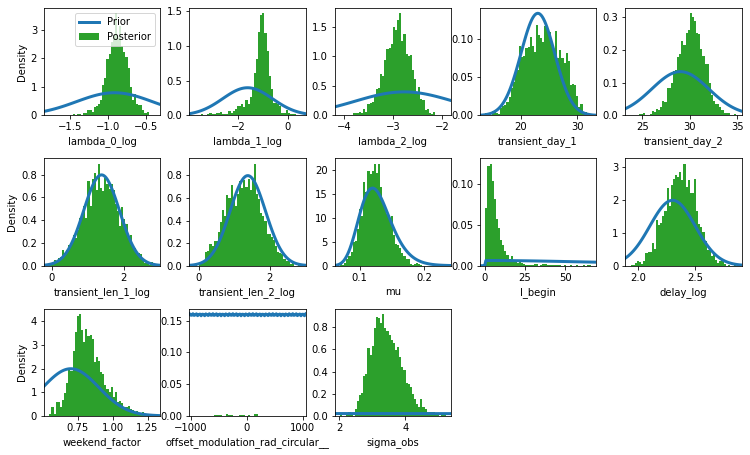

In [15]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

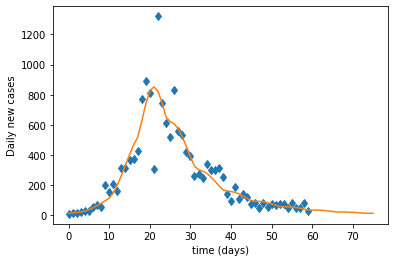

In [16]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

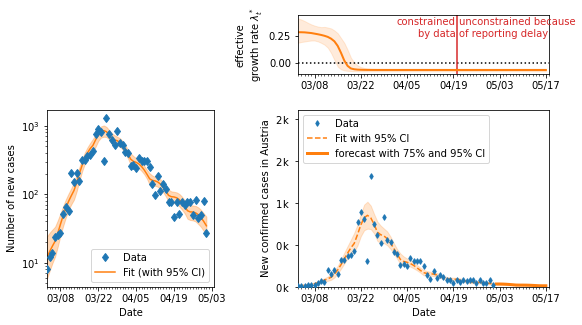

In [17]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="Austria")